## GHP Construction with Duration Matching

It was seen that it is a good idea to use zero-coupon bonds instead of cash in your Goal Hedging Portfolio. If you can find the perfect set of zero-coupon bonds that match your liabilities exactly, then it would be far better to just buy those zero-coupon bonds. The problem is that it is not always easy to find zero-coupon bonds that match your liabilities exactly. 

We can do something similar by holding a portfolio of regular coupon-bearing bonds or coupon-paying bonds as long as we can do this factor matching or duration-matching.

In [1]:
import numpy as np
import pandas as pd
import risk_kit as kit

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    Returns a series of cash flows generated by a bond, indexed by a coupon number.
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data = coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal
    return cash_flows

The principal is also the face-value of the bond. Coupon rate means it is going to pay coupons every single year (here -> 3% of the principal). A typical bond will pay once or twice a year, but there are some bonds that pay more often. Here coupons_per_year is assumed as 12 in order to work with monthly data easily and to ignore the bond prices in-between one coupon and another.

In [7]:
def bond_price(maturity, pricipal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Price a bond based on bond parameters maturity, principal, coupon rate and coupons_per_year 
    and the prevailing discount rate. 
    """
    cash_flows = bond_cash_flows(maturity, pricipal, coupon_rate, coupons_per_year)
    return kit.pv(cash_flows, discount_rate/coupons_per_year)

discount_rate/coupons_per_year is the interest rate per period.


*How does the bond price change with interest rate?*

As interest rates all bond prices rise.

Eg:

In [8]:
bond_price(20, 1000, 0.05, 2, .04)

1136.7773962036904

In [9]:
bond_price(20, 1000, 0.05, 2, .05)

1000.0000000000023

In [10]:
bond_price(20, 1000, 0.05, 2, .02)

1492.520291709342

***Why is it that using just a straight forward bond as a hedge is a problem?***

In [12]:
# Generate rates from 1% to 10%
rates = np.linspace(0.01, .10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [13]:
# What are the bond prices for each of these different interest rates of this bond?
prices = [bond_price(10, 1000, 0.05, 2, rate) for rate in rates]
prices

[1379.7483829333992,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727876,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089511,
 1016.5739967228162,
 979.7406048086303,
 944.5154728963505,
 910.8222676519945,
 878.5884967212596,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465673,
 737.0181469646424,
 712.209531536784,
 688.4447414365]

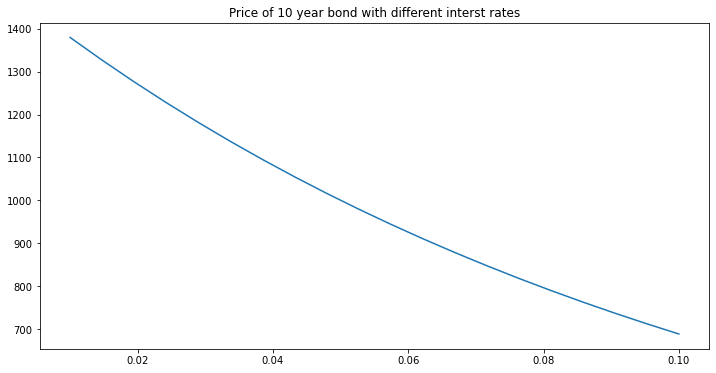

In [14]:
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10 year bond with different interst rates",
                                           legend=False, figsize=(12,6))

It shows that as the interest rates rise, the price of the bond falls. Therefore, using this 10-year bond as a hedge is not a good idea.

Now, we'll try and construct a combination of bonds that has some resilience to interest rates in much the same way that a zero-coupon bond has a resilience to interest rates. The reason that the zero-coupon bond has resilience to interest rates is because it basically comes down to just one payment. The interest rates in the middle doesn't matter. 

The problem with this bond is all these intermediate cash flows that are being generated.



In [16]:
# Look at cash flows of 3 year bond, 1000 face value, 6% coupon, 2 payments
cash_flows = bond_cash_flows(3, 1000, 0.06, 2)
cash_flows

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

*How long am I waiting before I get my cash flows?* 

One way to say is I have to wait for years to get the last cash flow.

Another way to look at it is to say, you are getting some cash before that last cashflow. So you can actually compute the weighted average time that it takes to get back the cash.

It is 6 periods in the above example. So I can compute the effective waiting period to get my money back. 

I have to compute what are the discount factors. Getting 30% today is better than getting some $30 out in the future. So I have to weight them not just by the cash flows but by the present value of the cash flows, and I do that by first finding what are the discount factors.

In [17]:
discounts = kit.discount(cash_flows.index, 0.06/2) # number of periods, discount/period
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [18]:
discounted_cashflow = discounts * cash_flows
discounted_cashflow

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

This is the discounted value or the present value of each of the cash flows given by that bond. So this bond is generating a sequence of cash flows, and these are the present values of those cash flows.

I can convert this into a set of weights:


In [20]:
weights = discounted_cashflow/discounted_cashflow.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

Now, I have to weight each of these periods. So take the index and multiply it by the discount cash flow, the weights. So, weighted average of all the periods:

In [22]:
(cash_flows.index * weights).sum()

5.579707187194534

The last payment is at 6, the maturity of the bond is at 6. But the weighted average duration that I have to wait, weighted by the present value of each of the cash flows is equal to 5.57 years. So effectively, I am not really weighting 6 years. I am literally weighting 6 years for my last payment, but I have already got some before that. So the weighted average duration that I am waiting is 5.57years, and this number is called a ***Maucaulay duration.***

The Maucaulay duration is the weighted average duration. It is directly related (not exactly related to but directly related to) to the rate of change, the first derivative of the price w.r.t interest rates. So if the interest rates move and you have a large duration, then the prices is going to move a lot. If you have a short duration, then the prices will not move as much. So the duration is directly linked to the amount by which the price will change when interest rates change.


In a zero-coupon bond, there is one payment. So the weighted average duration of that one payment, which is the duration of that payment, which is the maturity is the Maucaulay duration.


But every non-zero-coupon bond, one that pays intermediate coupons before maturity, it is going to have a duration shorter than the maturity of the bond. So this is the Maucaulay duration.

In [24]:
def macaulay_duration(cash_flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows.
    """
    discounted_flows = kit.discount(cash_flows.index, discount_rate) * cash_flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(cash_flows.index, weights=weights)

In [25]:
macaulay_duration(bond_cash_flows(3, 1000, 0.06, 2), .06/2)

5.579707187194534

If you can match the Macaulay duration of your bonds to the Macaulay duration of your liability, then you get two portfolios that have the same sensitivity - they change in the same way with changes in interest rate.

As interest rates move, your liabilities are going to go up but your bond portfolio is going to go up hopefully by the same amount. This is not a perfect matching. The reason is because, this only works for parallel shifts of the yield curve if interest rates as a whole go up. But the yield curve has more complex behaviour. It can steepen, it can flatten, it can show added curvature. Those are the additional added factors of the yield curve. But the level of the yield curve is the major factor.

### Duration Matching

In [26]:
import risk_kit as kit
# Assume 10 year and 12 year liability with an interest rate of 4%
liabilities = pd.Series(data=[100000, 100000], index=[10, 12])
# Try and build a portfolio which has the same duration as my liabilities.
kit.macaulay_duration(liabilities, .04)

10.960799385088393

I have a 10 year liability and 12 year liability but based on the interest rates of .04, your duration is 10.96.

Now, if I had a zer-coupon bond, I could just buy a zero-coupon bond with a duration of 10.96 or if I could buy 2 individual 10 year and 12 year zero-coupon bonds, that would be greattoo. Assume that zero-coupon bonds are not available and we only have a 10 year and 15 year bond that pays a 5% coupon  once a year and a face value of 1000. 

I have to construct a portfolio that has the duration of 10.96, for that I need to know the duration of the available bonds first.

In [27]:
md_10 = kit.macaulay_duration(kit.bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = kit.macaulay_duration(kit.bond_cash_flows(20, 1000, .05, 1), .04)
md_10, md_20

(8.190898824083233, 13.544718122145921)

It is surprising that the 20 year bond duration is much shorter, but that is actually because the present value of those last payments are actually much less.

***The duration is the weighted average and it is weighted by the present value of each of the cash flows.*** It is the weighted average time that you have to wait.

Now that I know the duration of these two bonds, all I have to do is to figure out what fraction of these two bonds I should hold.

In this case, the fraction in the short duration asset $w_s$ should be such that:
    $$ w_s \times 8.19 + (1 - w_s) \times 13.54 = 10.96 $$

More generally:
    $$ w_s \times d_s + (1 - w_s) \times d_l = d_t $$

Rearraging gives:
    $$ w_s = \frac{d_l - d_t}{d_l - d_s} $$

In [32]:
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective duration
    that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l-d_t)/(d_l-d_s)

In [33]:
short_bond = kit.bond_cash_flows(10, 1000, .05, 1)
long_bond = kit.bond_cash_flows(20, 1000, .05, 1)
w_s = kit.match_durations(liabilities, short_bond, long_bond, .04)
w_s

0.48263092069478974

This tells me to put 48% of your assets in the short bond and 52% in the long bond. To be able to do that, first I have to price the bonds. 

In [34]:
p_short = kit.bond_price(10, 1000, .05, 1, .04)
p_long = kit.bond_price(20, 1000, .05, 1, .04)
# assets - how much money do I have? Assume I have 200000 and I start with 130000
a_0 = 130000 
# To calculate Macaulay duration, I need cash flows that this portfolio is going to generate.
# portfolio_flows = cash flow short bond + cash from long bond
# money/price -> (a_0*w_s)/p_short
portfolio_flows = pd.concat([a_0*w_s*short_bond/p_short, a_0*(1-w_s)*long_bond/p_long ])
kit.macaulay_duration(portfolio_flows, 0.04)

10.960799385088393

In [ ]:
10.96 is the number of periods and the duration of this portfolio and the duration of my liabilities is the same.

Now, computethe funding ratio.

The funding ratio calculated earlier was for one asset:
    def funding_ratio(assets, liabilities, r):
        """
        Computes the funding ratio of some assets given liabilities and interest rate
        """
        return assets/pv(liabilities, r)

Now I am interested in a series of assets. The code can be modified to reflect that the asset itself could be a series of cashflows. Because, the assets I'm holding now are my bonds and bonds will generate a series of cashflows.  

In [37]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate 
    and current value of assets.
    """
    return pv(assets, r)/pv(liabilities, r)

In [41]:
# Cash funding Ratio or Current Funding Ratio
cfr = kit.funding_ratio(portfolio_flows, liabilities, 0.04)
cfr

0.9998760012192478

I am pretty much funded at this point (like .9998). To seeif I have solved the problem, what I'm going to look at a bunch of rates. Consider rates from 0 to 10% and look at 20 points along the way. Also, I will construct the funding ratio as these interest rates change for a bunch of different cash flows.

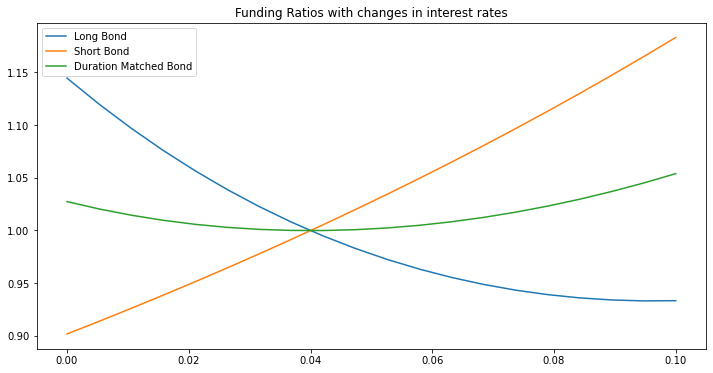

In [45]:
rates = np.linspace(0, 0.1, 20)
# a_0*w_s*short_bond/p_short
long_bond_assets = a_0*long_bond/p_long # 100% portfolio in long bond
short_bond_assets = a_0*short_bond/p_short # 100% portfolio in short bond

funding_ratio_changes = pd.DataFrame({
    "Long Bond": [kit.funding_ratio(long_bond_assets, liabilities, r) for r in rates],
    "Short Bond": [kit.funding_ratio(short_bond_assets, liabilities, r) for r in rates],
    "Duration Matched Bond": [kit.funding_ratio(portfolio_flows, liabilities, r) for r in rates]
}, index=rates)
funding_ratio_changes.plot(title="Funding Ratios with changes in interest rates", figsize=(12,6))

This shows that
1. If I had put all my money in the long bond:
    - if interest rates came down, my funding ratio would go up.
    - but if rates went up, my funding ratio would have plunged.
2. If I had put all my money in the short bond:
    - if interest rates went down, I would have suffered. 
    - if interest rates went up, I would have done well.
3. DURATION MATCHED Portfolio:
    - when interest rates change there is almost no change in the funding ratio.


So in the actual world where you have bonds that pay coupons and have no access to zero-coupon bond, you construct a portfolio using regular bonds which have all these intermediate payments, but you try and make sure that the liability has a duration that is matched by your assets. So you compute the duration of your liabilities, the duration of your assets and if those two are not the same then you have exposure to interest rate risk. But, at least the first level matching for parallel shifts in the yield curve when interest rates generally go up or down can be done.